In [42]:
import torch
from typing import List
import os
import sys
import hashlib
import json
import math

from os.path import join

base_dir = "../"
sys.path.insert(0, base_dir)

from stable_diffusion2.utils.utils import (
    check_device,
    get_memory_status,
    to_pil,
    save_image_grid,
    show_image_grid,
)
from stable_diffusion2.constants import ModelsPathTree
from stable_diffusion2 import StableDiffusion
from stable_diffusion2.model.clip_image_encoder import CLIPImageEncoder
from stable_diffusion2.model.clip_text_embedder import CLIPTextEmbedder

# EMBEDDED_PROMPTS_DIR = os.path.abspath(join(base_dir, "/input/embedded_prompts/"))
EMBEDDED_PROMPTS_DIR = os.path.abspath(join(base_dir, "./input/embedded_prompts/"))
print(EMBEDDED_PROMPTS_DIR)
OUTPUT_DIR = os.path.abspath(
    join(base_dir, "./output/sd2-notebook/disturbed_embeddings/")
)
IMAGES_DIR = os.path.abspath(join(OUTPUT_DIR, "images/"))
FEATURES_DIR = os.path.abspath(join(OUTPUT_DIR, "features/"))
print(OUTPUT_DIR)
print(IMAGES_DIR)
print(FEATURES_DIR)
NULL_PROMPT = ""
PROMPT = (
    "A woman with flowers in her hair in a courtyard, in the style of Frank Frazetta"
)
NUM_ITERATIONS = 10
SEED = 2982
NOISE_MULTIPLIER = 0.01
BATCH_SIZE = 1


# DEVICE = input("Set device: 'cuda:i' or 'cpu'")
DEVICE = None
DEVICE = check_device(DEVICE)
pt = ModelsPathTree(base_directory=base_dir)

os.makedirs(EMBEDDED_PROMPTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(FEATURES_DIR, exist_ok=True)

c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\embedded_prompts
c:\Users\igor-\.cloned\kcg-ml-sd1p4\output\sd2-notebook\disturbed_embeddings
c:\Users\igor-\.cloned\kcg-ml-sd1p4\output\sd2-notebook\disturbed_embeddings\images
c:\Users\igor-\.cloned\kcg-ml-sd1p4\output\sd2-notebook\disturbed_embeddings\features
INFO: `device` is None. Falling back to current device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [43]:
def calculate_sha256(tensor):
    if tensor.device == "cpu":
        tensor_bytes = tensor.numpy().tobytes()  # Convert tensor to a byte array
    else:
        tensor_bytes = tensor.cpu().numpy().tobytes()  # Convert tensor to a byte array
    sha256_hash = hashlib.sha256(tensor_bytes)
    return sha256_hash.hexdigest()


def embed_and_save_prompts(prompts: list, null_prompt=NULL_PROMPT):
    null_prompt = null_prompt
    prompts = prompts

    clip_text_embedder = CLIPTextEmbedder(device=check_device())
    clip_text_embedder.load_submodels(**pt.embedder_submodels)

    null_cond = clip_text_embedder(null_prompt)
    torch.save(null_cond, join(EMBEDDED_PROMPTS_DIR, "null_cond.pt"))
    print(
        "Null prompt embedding saved at: ",
        f"{join(EMBEDDED_PROMPTS_DIR, 'null_cond.pt')}",
    )

    embedded_prompts = clip_text_embedder(prompts)
    torch.save(embedded_prompts, join(EMBEDDED_PROMPTS_DIR, "embedded_prompts.pt"))

    print(
        "Prompts embeddings saved at: ",
        f"{join(EMBEDDED_PROMPTS_DIR, 'embedded_prompts.pt')}",
    )

    get_memory_status()
    clip_text_embedder.to("cpu")
    del clip_text_embedder
    torch.cuda.empty_cache()
    get_memory_status()

    return embedded_prompts, null_cond

In [44]:
embedded_prompts, null_prompt = embed_and_save_prompts(PROMPT)
embedding = embedded_prompts

INFO: `device` is None. Falling back to current device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Device given. Using device cuda:0`device` is None. Falling back to current device: cuda:0.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Null prompt embedding saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\embedded_prompts\null_cond.pt
Prompts embeddings saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\embedded_prompts\embedded_prompts.pt
Total: 12287 MiB
Free: 2578 MiB
Used: 9709 MiB
Total: 12287 MiB
Free: 4464 MiB
Used: 7823 MiB


In [45]:
# check the shape of the embedded prompts
embedding_shape = tuple(embedded_prompts.shape)
embedding_shape

(1, 77, 768)

In [46]:
# check mean and std to use the same for the noise generation
# one idea is to use one distribution per position (in the 77 positions)
# in this case we would check the mean and std along dimension 2
# embedded_prompts.mean(dim=2), embedded_prompts.std(dim=2)
embedding_mean, embedding_std = embedded_prompts.mean(), embedded_prompts.std()
embedding_mean, embedding_std

(tensor(-0.1095, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9981, device='cuda:0', grad_fn=<StdBackward0>))

In [47]:
embedded_prompts.mean(dim=2), embedded_prompts.std(dim=2)
noise = torch.normal(mean=embedded_prompts.mean(dim=2), std=embedded_prompts.std(dim=2))

In [48]:
# mean and std along dimension 2 (77 positions)
embedded_prompts.mean(dim=2), embedded_prompts.std(dim=2)

(tensor([[-0.1049, -0.1104, -0.1121, -0.1152, -0.1107, -0.1197, -0.1112, -0.1156,
          -0.1177, -0.1155, -0.1082, -0.1158, -0.1133, -0.1080, -0.1053, -0.1108,
          -0.0991, -0.1007, -0.1043, -0.1103, -0.1103, -0.1103, -0.1103, -0.1103,
          -0.1103, -0.1103, -0.1103, -0.1103, -0.1103, -0.1103, -0.1103, -0.1104,
          -0.1104, -0.1104, -0.1104, -0.1104, -0.1103, -0.1103, -0.1102, -0.1102,
          -0.1101, -0.1100, -0.1099, -0.1098, -0.1097, -0.1096, -0.1095, -0.1094,
          -0.1093, -0.1092, -0.1091, -0.1091, -0.1090, -0.1090, -0.1089, -0.1088,
          -0.1087, -0.1086, -0.1085, -0.1083, -0.1082, -0.1082, -0.1082, -0.1081,
          -0.1081, -0.1080, -0.1080, -0.1079, -0.1079, -0.1078, -0.1078, -0.1078,
          -0.1077, -0.1077, -0.1076, -0.1077, -0.1077]], device='cuda:0',
        grad_fn=<MeanBackward1>),
 tensor([[1.5788, 1.0236, 1.0283, 0.9993, 1.0214, 0.9961, 0.9998, 1.0058, 0.9931,
          0.9961, 1.0059, 0.9858, 0.9820, 0.9906, 0.9839, 0.9897, 1.0050

In [49]:
dist = torch.distributions.normal.Normal(
    loc=embedded_prompts.mean(dim=2), scale=embedded_prompts.std(dim=2)
)
noise = dist.sample(sample_shape=torch.Size([768])).permute(1, 0, 2).permute(0, 2, 1)
noise.shape

torch.Size([1, 77, 768])

In [50]:
differences = []
differences_means = []
differences_norms = []
differences_stds = []
dot_products = []
for i, row in enumerate(embedded_prompts.squeeze()):
    if i == 0:
        continue
    diff = row - embedded_prompts.squeeze()[0]
    differences.append(diff)
    differences_means.append(diff.mean())
    differences_norms.append(diff.norm())
    differences_stds.append(diff.std())
    dot_products.append(torch.dot(row, embedded_prompts.squeeze()[0]))

In [51]:
differences = torch.stack(differences)
differences_means = torch.stack(differences_means)
differences_norms = torch.stack(differences_norms)
differences_stds = torch.stack(differences_stds)
dot_products = torch.stack(dot_products)

In [52]:
differences.shape

torch.Size([76, 768])

In [53]:
differences_means

tensor([-0.0055, -0.0072, -0.0102, -0.0058, -0.0148, -0.0062, -0.0106, -0.0128,
        -0.0106, -0.0033, -0.0109, -0.0084, -0.0031, -0.0004, -0.0058,  0.0059,
         0.0042,  0.0006, -0.0054, -0.0053, -0.0054, -0.0053, -0.0053, -0.0053,
        -0.0053, -0.0054, -0.0054, -0.0054, -0.0054, -0.0054, -0.0054, -0.0055,
        -0.0055, -0.0054, -0.0054, -0.0054, -0.0054, -0.0053, -0.0052, -0.0052,
        -0.0051, -0.0050, -0.0049, -0.0048, -0.0047, -0.0046, -0.0044, -0.0043,
        -0.0043, -0.0042, -0.0042, -0.0041, -0.0041, -0.0040, -0.0039, -0.0038,
        -0.0037, -0.0035, -0.0034, -0.0033, -0.0032, -0.0032, -0.0032, -0.0032,
        -0.0031, -0.0030, -0.0030, -0.0029, -0.0029, -0.0029, -0.0028, -0.0028,
        -0.0028, -0.0027, -0.0027, -0.0028], device='cuda:0',
       grad_fn=<StackBackward0>)

In [54]:
differences_stds

tensor([2.0543, 1.6308, 1.7727, 1.6842, 1.9204, 1.8844, 1.8511, 1.9100, 1.9835,
        1.7336, 1.8886, 1.9559, 1.9857, 1.8687, 2.0454, 1.9183, 1.9132, 1.8261,
        1.8610, 1.8526, 1.8465, 1.8422, 1.8402, 1.8390, 1.8376, 1.8372, 1.8365,
        1.8367, 1.8374, 1.8381, 1.8392, 1.8394, 1.8406, 1.8418, 1.8429, 1.8449,
        1.8466, 1.8485, 1.8503, 1.8515, 1.8532, 1.8540, 1.8558, 1.8557, 1.8566,
        1.8571, 1.8586, 1.8600, 1.8617, 1.8632, 1.8643, 1.8670, 1.8682, 1.8703,
        1.8714, 1.8720, 1.8744, 1.8752, 1.8757, 1.8748, 1.8753, 1.8759, 1.8754,
        1.8774, 1.8775, 1.8794, 1.8809, 1.8822, 1.8850, 1.8864, 1.8879, 1.8888,
        1.8897, 1.8914, 1.8921, 1.8863], device='cuda:0',
       grad_fn=<StackBackward0>)

In [55]:
differences_norms

tensor([56.8947, 45.1664, 49.0956, 46.6443, 53.1869, 52.1886, 51.2675, 52.8980,
        54.9320, 48.0122, 52.3056, 54.1695, 54.9945, 51.7525, 56.6475, 53.1273,
        52.9858, 50.5727, 51.5388, 51.3075, 51.1394, 51.0206, 50.9637, 50.9308,
        50.8908, 50.8814, 50.8617, 50.8680, 50.8866, 50.9071, 50.9378, 50.9428,
        50.9744, 51.0073, 51.0382, 51.0951, 51.1409, 51.1948, 51.2448, 51.2784,
        51.3237, 51.3459, 51.3963, 51.3942, 51.4182, 51.4308, 51.4736, 51.5116,
        51.5586, 51.6015, 51.6302, 51.7068, 51.7392, 51.7987, 51.8275, 51.8438,
        51.9101, 51.9344, 51.9471, 51.9226, 51.9355, 51.9533, 51.9375, 51.9930,
        51.9983, 52.0503, 52.0919, 52.1285, 52.2036, 52.2434, 52.2864, 52.3091,
        52.3341, 52.3809, 52.4009, 52.2393], device='cuda:0',
       grad_fn=<StackBackward0>)

In [56]:
dot_products

tensor([-251.9275,  350.4521,  142.9432,  277.0898,  -68.3092,  -13.6321,
          39.0197,  -55.4780, -162.9905,  200.0536,  -29.9826, -132.3382,
        -171.2792,   -3.5261, -263.9709,  -60.0389,  -43.1525,   64.7434,
          11.1163,   23.2465,   31.8797,   38.0612,   40.7107,   42.0947,
          43.6369,   43.4621,   43.9183,   42.8580,   41.2993,   39.7537,
          37.6807,   37.1943,   35.3143,   33.3618,   31.7590,   28.6663,
          26.3014,   23.5304,   20.9072,   19.2350,   16.9832,   15.9356,
          13.6023,   13.9413,   13.1260,   12.6738,   10.8078,    8.8505,
           6.4818,    4.3586,    2.8671,   -0.9004,   -2.4419,   -5.2499,
          -6.6959,   -7.2302,  -10.4100,  -11.4401,  -11.8144,  -10.5489,
         -11.1119,  -11.8568,  -10.8934,  -13.4565,  -13.6953,  -16.1756,
         -18.2860,  -20.2066,  -23.9710,  -26.1684,  -28.1914,  -29.3550,
         -30.4042,  -32.4547,  -33.4260,  -25.6728], device='cuda:0',
       grad_fn=<StackBackward0>)

In [57]:
# generate noise and add to the embedded prompt
generator = torch.Generator(device=DEVICE).manual_seed(SEED)
# noise = torch.normal(
#     mean=embedding_mean.item(),
#     std=embedding_std.item(),
#     size=embedding_shape,
#     device=DEVICE,
#     generator=generator,
# )
# noise.shape

dist = torch.distributions.normal.Normal(
    loc=embedded_prompts.mean(dim=2), scale=embedded_prompts.std(dim=2)
)
noise = dist.sample(sample_shape=torch.Size([768])).permute(1, 0, 2).permute(0, 2, 1)
noise.shape

torch.Size([1, 77, 768])

In [58]:
embedding_e = embedded_prompts + 0.1 * noise

In [59]:
get_memory_status()

Total: 12287 MiB
Free: 4464 MiB
Used: 7823 MiB


In [60]:
%%capture
sd = StableDiffusion(device=DEVICE)
sd.quick_initialize().load_autoencoder(**pt.autoencoder).load_decoder(**pt.decoder)
sd.model.load_unet(**pt.unet)

In [61]:
get_memory_status()

Total: 12287 MiB
Free: 4464 MiB
Used: 7823 MiB


In [62]:
image = sd.generate_images_from_embeddings(
    seed=SEED, embedded_prompt=embedded_prompts, null_prompt=null_prompt
)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

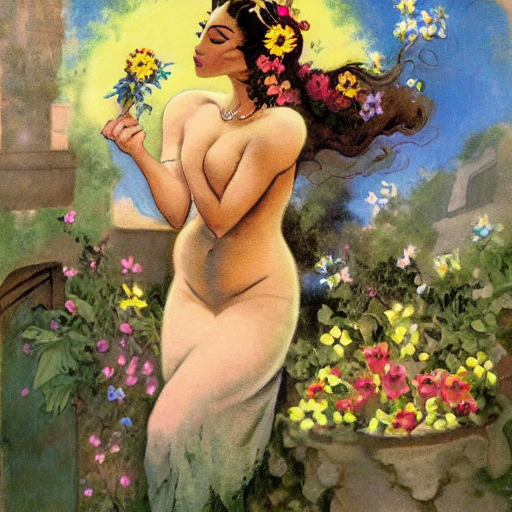

In [63]:
to_pil(image[0])

In [64]:
image_e = sd.generate_images_from_embeddings(
    seed=SEED, embedded_prompt=embedding_e, null_prompt=null_prompt
)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

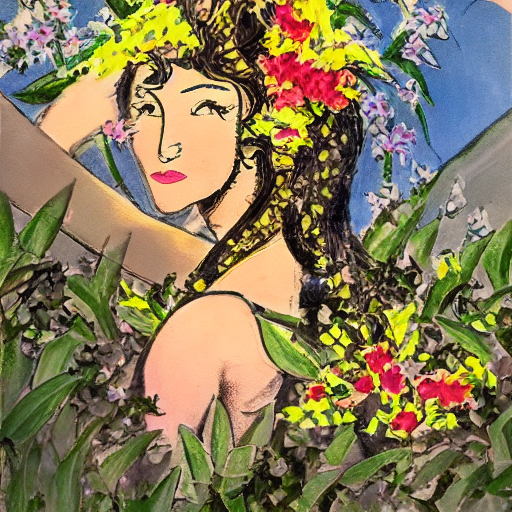

In [65]:
to_pil(image_e[0])

In [66]:
def generate_images_from_disturbed_embeddings(
    sd: StableDiffusion,
    embedded_prompt: torch.Tensor,
    device=DEVICE,
    seed=SEED,
    num_iterations=NUM_ITERATIONS,
    noise_multiplier=NOISE_MULTIPLIER,
    batch_size=BATCH_SIZE,
):
    generator = torch.Generator(device=device).manual_seed(seed)

    embedding_mean, embedding_std = embedded_prompt.mean(), embedded_prompt.std()
    embedding_shape = tuple(embedded_prompt.shape)

    # noise = torch.normal(
    #     mean=embedding_mean.item(),
    #     std=embedding_std.item(),
    #     size=embedding_shape,
    #     device=device,
    #     generator=generator,
    # )
    # test with standard normal distribution
    # noise = torch.normal(
    #     mean=0.0,
    #     std=1.0,
    #     size=embedding_shape,
    #     device=device,
    #     generator=generator,
    # )
    # embedded_prompt.mean(dim=2), embedded_prompt.std(dim=2)
    # noise = torch.normal(
    #     mean=embedded_prompt.mean(dim=2), std=embedded_prompt.std(dim=2)
    # )
    dist = torch.distributions.normal.Normal(
        loc=embedded_prompt.mean(dim=2), scale=embedded_prompt.std(dim=2)
    )

    for i in range(0, num_iterations):
        j = num_iterations - i

        noise_i = (
            dist.sample(sample_shape=torch.Size([768]))
            .permute(1, 0, 2)
            .permute(0, 2, 1)
        )
        noise_j = (
            dist.sample(sample_shape=torch.Size([768]))
            .permute(1, 0, 2)
            .permute(0, 2, 1)
        )
        embedding_e = embedded_prompt + (
            (i * noise_multiplier) * noise_i + (j * noise_multiplier) * noise_j
        ) / (2 * num_iterations)

        image_e = sd.generate_images_from_embeddings(
            seed=seed,
            embedded_prompt=embedding_e,
            null_prompt=null_prompt,
            batch_size=batch_size,
        )

        yield (image_e, embedding_e)

In [67]:
image_generator = generate_images_from_disturbed_embeddings(
    sd, embedded_prompts)

In [68]:
yielded = list(image_generator)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

In [69]:
images = [image[0] for image in yielded]
embeddings = [image[1] for image in yielded]
hashs = [calculate_sha256(image[0]) for image in yielded]

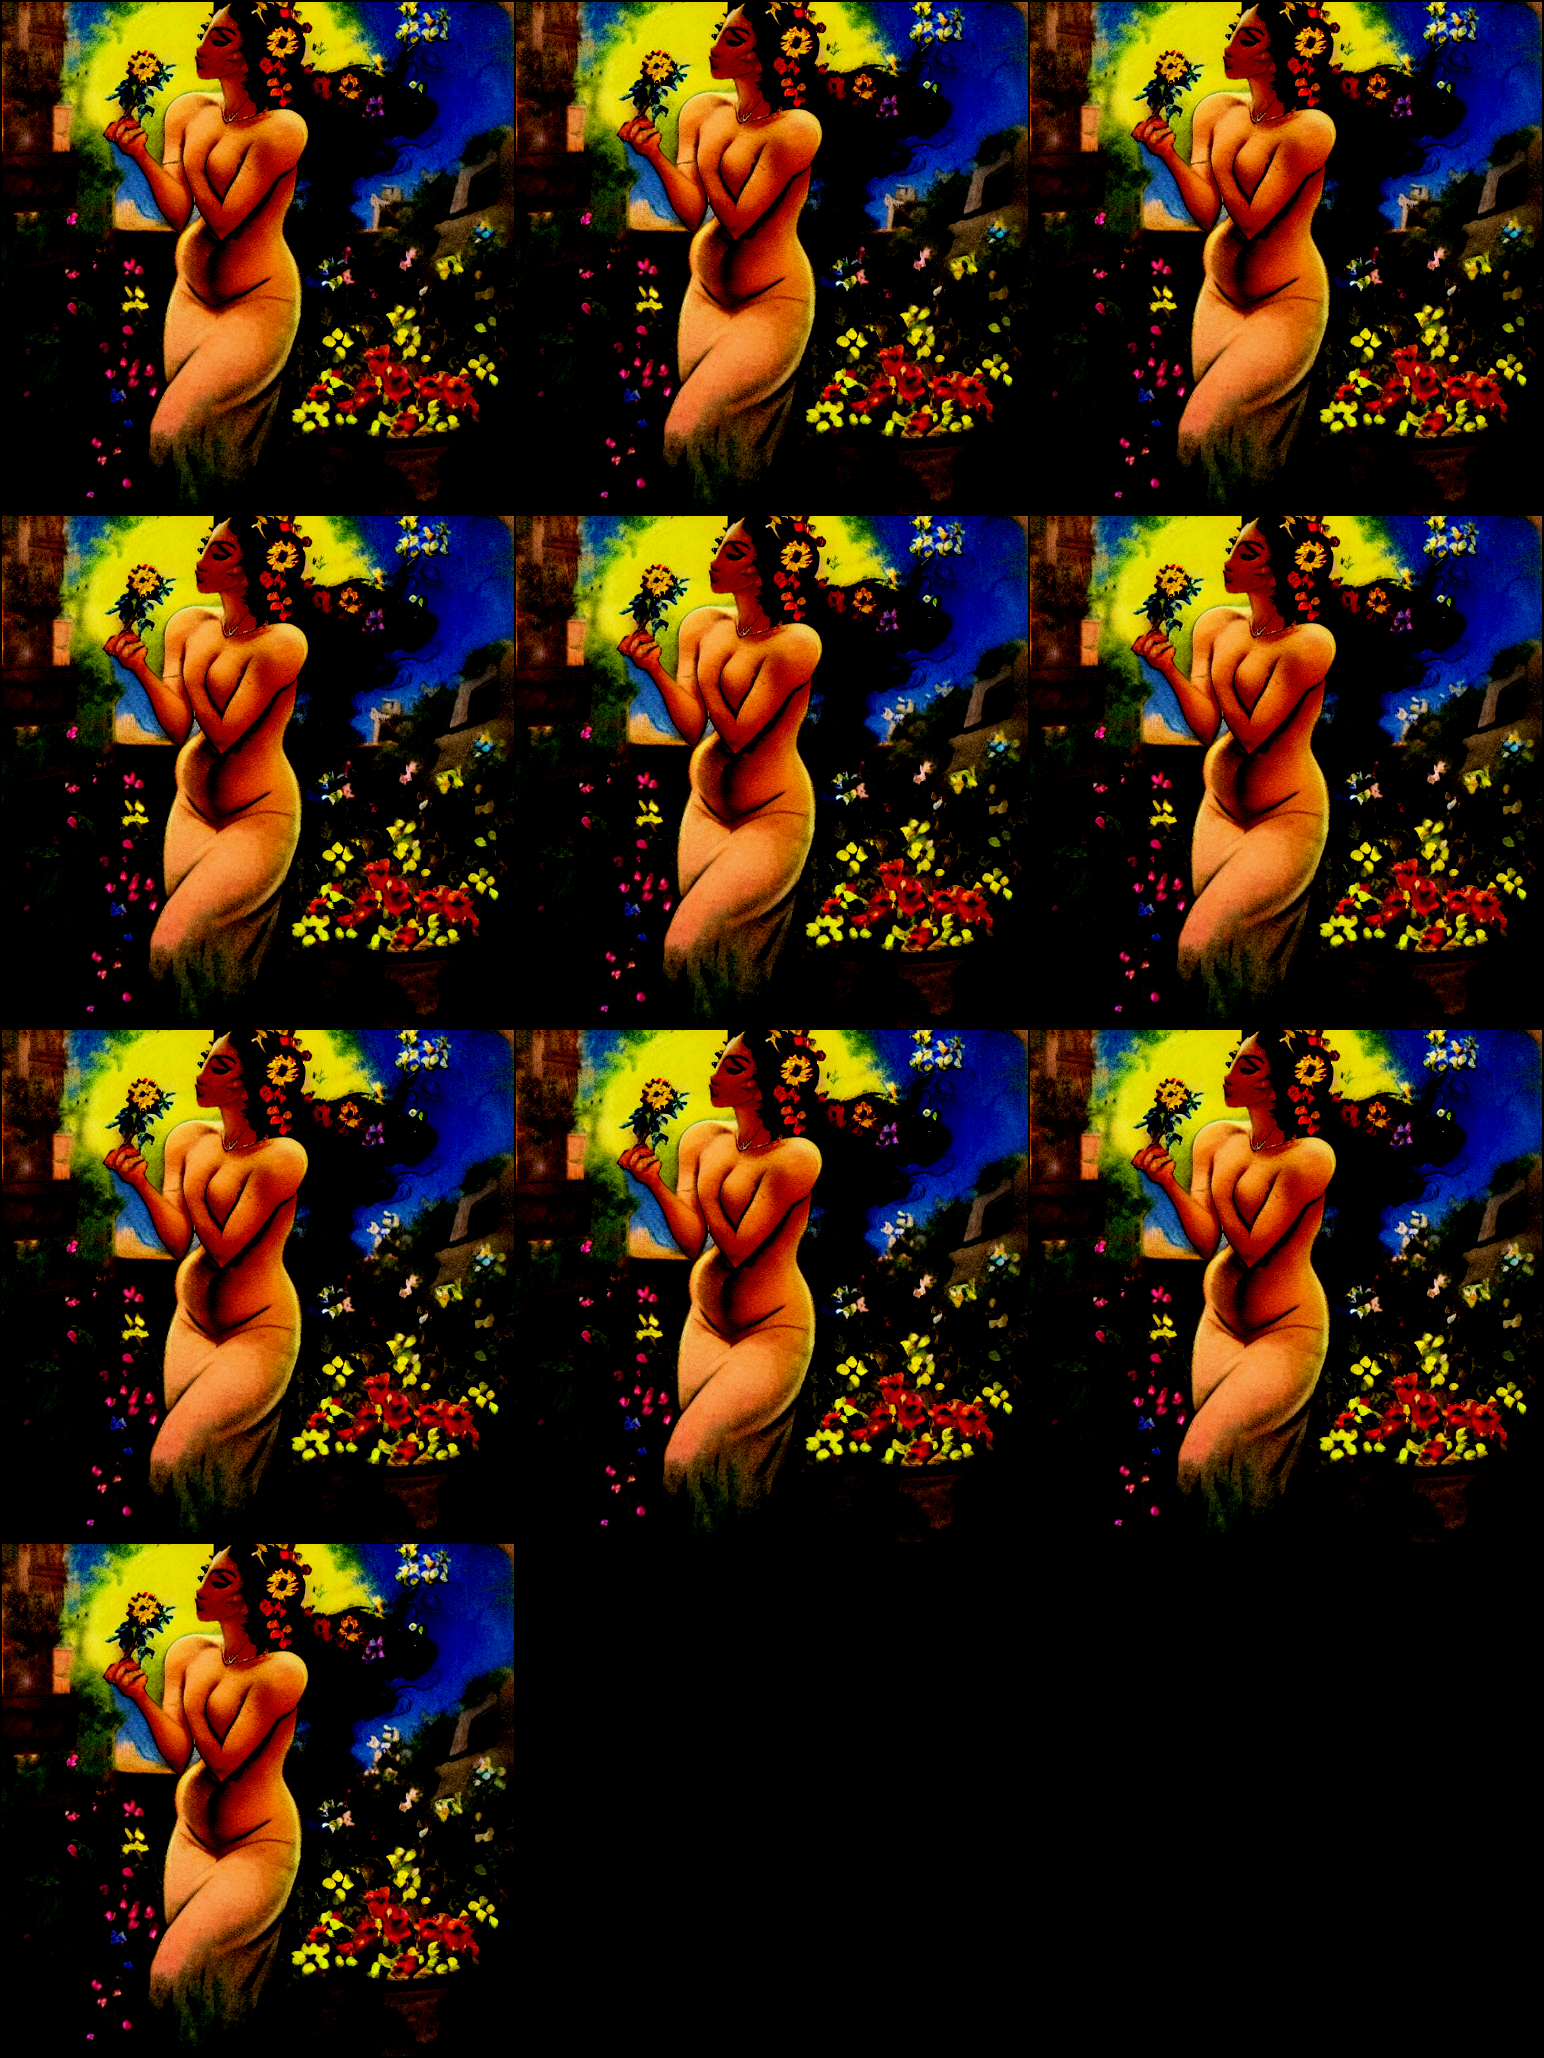

In [70]:
show_image_grid(torch.cat(images), nrow=int(math.log(NUM_ITERATIONS, 2)))

In [73]:
pil_images = list(map(to_pil, map(torch.Tensor.squeeze, images)))

In [74]:
from torch import nn
import clip


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


chadscorer_path = join("../input/model/aesthetic_scorer", "chadscorer.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"

pt_state = torch.load(chadscorer_path, map_location=torch.device("cpu"))

# CLIP embedding dim is 768 for CLIP ViT L 14
predictor = AestheticPredictor(768)
predictor.load_state_dict(pt_state)
predictor.to(device)
predictor.eval()

clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)


def get_image_features(
    image, device=device, model=clip_model, preprocess=clip_preprocess
):
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        # l2 normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)
    image_features = image_features.cpu().detach().numpy()
    return image_features


def get_score(image):
    image_features = get_image_features(image)
    score = predictor(torch.from_numpy(image_features).to(device).float())
    return score.item()

In [75]:
images_data = []
manifest = []

for i, image in enumerate(pil_images):
    # hash = hashlib.sha256(image).hexdigest()
    image_tensor = images[i]
    image_name = f"image_{i}.png"
    image_path = os.path.abspath(join(IMAGES_DIR, image_name))
    image_hash = calculate_sha256(image_tensor)
    image_features = get_image_features(image)
    image_score = get_score(image)
    manifest_i = {
        "file-name": image_name,
        "file-hash": image_hash,
        "file-path": image_path,
        "aesthetic-score": image_score,
        "initial-prompt": PROMPT,
    }
    manifest.append(manifest_i)

    json_output_i = manifest_i.copy()
    json_output_i["initial-prompt"] = PROMPT
    json_output_i["embedding-tensor"] = embedding.tolist()
    json_output_i["clip-vector"] = image_features.tolist()
    images_data.append(json_output_i)
    image.save(image_path)
    # images_data.append(
    #     {
    #         "file-name": image_name,
    #         "file-hash": image_hash,
    #         "file-path": image_path,
    #         "aesthetic-score": image_score,
    #         "initial-prompt": PROMPT,
    #         "embedding-tensor": embeddings[i].tolist(),
    #         "clip-vector": image_features.tolist(),
    #     }
    # )

json.dump(images_data, open(join(FEATURES_DIR, "features.json"), "w"), indent=4)
print("Features saved at: ", join(FEATURES_DIR, "features.json"))
json.dump(manifest, open(join(OUTPUT_DIR, "manifest.json"), "w"), indent=4)
print("Manifest saved at: ", join(OUTPUT_DIR, "manifest.json"))

Features saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\output\sd2-notebook\disturbed_embeddings\features\features.json
Manifest saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\output\sd2-notebook\disturbed_embeddings\manifest.json
